Loop through Kaggle input directory, print file paths. Numpy, pandas used.

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as nnf
import torch.optim as optim

import numpy as np
import csv
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns



## Analytical solution

Simulates temperature distribution on plate, specifying conditions, using numerical method.

In [4]:
plate_length = 20
max_iter_time = 100

alpha = 4.0
delta_x = 1

# Calculated params
delta_t = (delta_x ** 2)/(4 * alpha)
gamma = (alpha * delta_t) / (delta_x ** 2)

# Initialize solution: the grid of u(k, i, j)
u = np.empty((max_iter_time, plate_length, plate_length))

# Initial condition everywhere inside the grid
u_initial = 0.0
# Set the initial condition
u.fill(u_initial)

# Boundary conditions (fixed temperature)
u_top = 100.0
u_left = 100.0
u_bottom = 0.0
u_right = 0.0


# Set the boundary conditions
u[:, (plate_length-1):, :] = u_top
u[:, :, :1] = u_left
u[:, :1, 1:] = u_bottom
u[:, :, (plate_length-1):] = u_right

# center_start, center_end = plate_length//2 - 2, plate_length//2 + 2
# u[:, center_start:center_end, center_start:center_end] = 100



Function calculates temperature distribution on plate over time using finite difference method, returning updated array.

In [5]:
def calculate(u):
  for k in range(0, max_iter_time-1, 1):
    for i in range(1, plate_length-1, delta_x):
      for j in range(1, plate_length-1, delta_x):
        u[k + 1, i, j] = gamma * (u[k][i+1][j] + u[k][i-1][j] + u[k][i][j+1] + u[k][i][j-1] - 4*u[k][i][j]) + u[k][i][j]

  return u

ut = calculate(u)
print(ut.shape)

(100, 20, 20)


Function creates animated heatmap of temperature data over time.

In [6]:
def animate_heatmap_blit(heatmaps, delta_t, interval=40):

    fig, ax = plt.subplots(figsize=(6, 4))

    cax = ax.pcolormesh(heatmaps[0,...], cmap='hot')
    fig.colorbar(cax)

    def animate(i):
        cax.set_array(heatmaps[i, ...].flatten())
        ax.set_title(f"Time={i*delta_t:.3f}")
        return cax,

    anim = FuncAnimation(fig, animate, interval=interval, frames=len(heatmaps), blit=True)

    return anim

Function animates heatmap of temperature data without blitting for performance.

In [7]:
def animate_heatmap_noblit(heatmaps, delta_t, interval=40):
#     https://brushingupscience.com/2016/06/21/matplotlib-animations-the-easy-way/

    fig, ax = plt.subplots(figsize=(6, 4))

    cax = ax.pcolormesh(heatmaps[0,...], cmap='hot')
    fig.colorbar(cax)

    def animate(i):
        cax = ax.pcolormesh(heatmaps[i,...], cmap='hot')
        ax.set_title(f"Time={i*delta_t:.3f}")

    anim = FuncAnimation(fig, animate, interval=interval, frames=len(heatmaps))

    return anim

The code converts the animation generated by the `animate_heatmap_blit` function into HTML format using `.to_jshtml()` and displays it inline in a Jupyter notebook using `HTML(...)`.

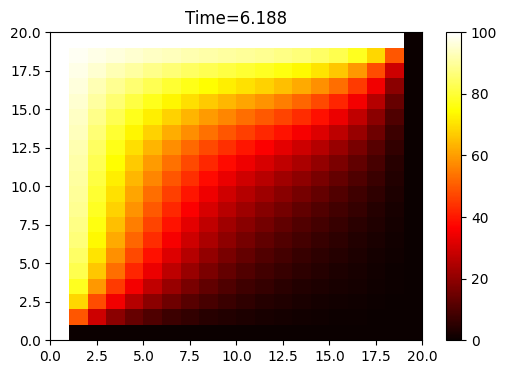

In [8]:
HTML(animate_heatmap_blit(ut, delta_t).to_jshtml())

## Preprocess data

Code generates Cartesian product, converts to PyTorch tensor comprehensively.

In [9]:
torch.tensor(list(itertools.product(range(2), range(3), range(3))))

tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 0, 2],
        [0, 1, 0],
        [0, 1, 1],
        [0, 1, 2],
        [0, 2, 0],
        [0, 2, 1],
        [0, 2, 2],
        [1, 0, 0],
        [1, 0, 1],
        [1, 0, 2],
        [1, 1, 0],
        [1, 1, 1],
        [1, 1, 2],
        [1, 2, 0],
        [1, 2, 1],
        [1, 2, 2]])

`preprocess_data` generates combinations, reshapes, flattens, verifies, returns preprocessed tensors.

In [10]:
def preprocess_data(max_iter_time, plate_length, data_array):
    # input = (time, space1, space2, ...)

    indata = torch.tensor( list(itertools.product(range(max_iter_time), range(plate_length), range(plate_length))),
                         dtype=torch.float)
    assert indata.shape == (max_iter_time * plate_length * plate_length, 3)

#     output = heatmap value
    outdata = torch.tensor(data_array.flatten(), dtype=torch.float)
    assert outdata.shape == (max_iter_time * plate_length * plate_length,)

    return indata, outdata

input_data, output_data = preprocess_data(max_iter_time, plate_length, ut)

Validate preprocessing by comparing original and preprocessed temperature data.

In [11]:
index = np.random.randint(len(output_data))
time, space1, space2 = input_data[index].numpy().astype(int)
print(ut[time, space1, space2], output_data[index])

0.0 tensor(0.)


Split input and output data for training and validation sets.

In [12]:
def train_valid_split(indata, outdata, train_timestep, platelength):
#     split by timestep
    train_end_index = int(train_timestep * platelength * platelength)

    train_indata = indata[:train_end_index]
    train_outdata = indata[:train_end_index]

    valid_indata = indata[train_end_index:]
    valid_outdata = outdata[train_end_index:]

    return train_indata, train_outdata, valid_indata, valid_outdata

train_timestep = int(max_iter_time * 0.5)
train_input, train_output, valid_input, valid_output = train_valid_split(
    input_data, output_data, train_timestep=train_timestep, platelength=plate_length)

print(train_input.shape, train_output.shape)
print(train_input[-1], valid_input[0])

torch.Size([20000, 3]) torch.Size([20000, 3])
tensor([49., 19., 19.]) tensor([50.,  0.,  0.])


Sample constraint points with even time, row, and column indices.

In [13]:
def sample_constraint_points(indata):
    input_size = len(indata)
#     point_indexes = np.arange(0, input_size, input_size//20000)
    constraintpoints = torch.tensor( list(itertools.product(range(0, max_iter_time, 2), range(0, plate_length, 2), range(0, plate_length, 2))),
        dtype=torch.float)

#     print(points)

#     return input_data[point_indexes]
    return constraintpoints

constraint_points = sample_constraint_points(input_data)
print(constraint_points.shape)

torch.Size([5000, 3])


## Neural network

Define fully connected neural network with specified layers, perform forward pass.

In [14]:
# prompt: generate a pinn archetecture for heat diffusion detection in water body

class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.relu = nn.ReLU()

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
        return x

layers = [3, 20, 20, 20, 20, 1]
model = PINN(layers)

x = torch.randn(10, 3)
y = model(x)
print(y.shape)


torch.Size([10, 1])


In [15]:

# Define PINN architecture
class PINN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_prob=0.5):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        for layer in self.layers:
            x = self.relu(layer(x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return self.sigmoid(x)

In [16]:

# Prepare data
# Example data preparation (replace with your actual data loading/preprocessing)
X = np.random.randn(1000, 3)  # Sample features
y = np.random.randint(0, 2, (1000, 1))  # Sample labels, assuming binary classification

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Define model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_sizes = [64, 32, 16]  # Adjusted layer sizes
output_size = 1
model = PINN(input_size, hidden_sizes, output_size)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [17]:
# Training
num_epochs = 1000
train_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/1000], Loss: 0.6958
Epoch [20/1000], Loss: 0.6951
Epoch [30/1000], Loss: 0.6939
Epoch [40/1000], Loss: 0.6915
Epoch [50/1000], Loss: 0.6940
Epoch [60/1000], Loss: 0.6928
Epoch [70/1000], Loss: 0.6920
Epoch [80/1000], Loss: 0.6906
Epoch [90/1000], Loss: 0.6901
Epoch [100/1000], Loss: 0.6909
Epoch [110/1000], Loss: 0.6931
Epoch [120/1000], Loss: 0.6921
Epoch [130/1000], Loss: 0.6887
Epoch [140/1000], Loss: 0.6877
Epoch [150/1000], Loss: 0.6886
Epoch [160/1000], Loss: 0.6945
Epoch [170/1000], Loss: 0.6914
Epoch [180/1000], Loss: 0.6850
Epoch [190/1000], Loss: 0.6871
Epoch [200/1000], Loss: 0.6874
Epoch [210/1000], Loss: 0.6895
Epoch [220/1000], Loss: 0.6869
Epoch [230/1000], Loss: 0.6868
Epoch [240/1000], Loss: 0.6916
Epoch [250/1000], Loss: 0.6784
Epoch [260/1000], Loss: 0.6915
Epoch [270/1000], Loss: 0.6848
Epoch [280/1000], Loss: 0.6901
Epoch [290/1000], Loss: 0.6850
Epoch [300/1000], Loss: 0.6832
Epoch [310/1000], Loss: 0.6839
Epoch [320/1000], Loss: 0.6871
Epoch [330/1000],

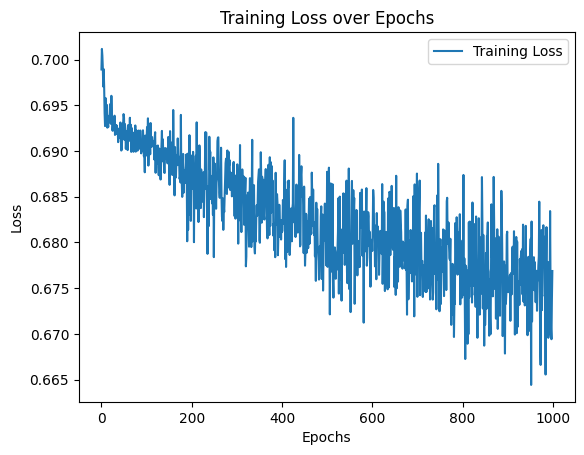

In [18]:

# Plot training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()



Accuracy: 0.5050, Precision: 0.5082, F1 Score: 0.5561, Loss: 0.6970


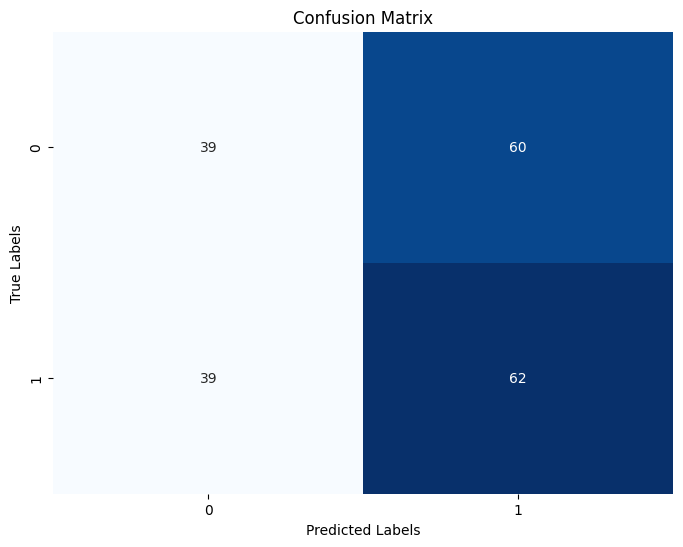

In [19]:

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    predictions = torch.round(outputs).squeeze().numpy()  # Round the probabilities
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    loss = criterion(outputs, y_test_tensor).item()

print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, F1 Score: {f1:.4f}, Loss: {loss:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:


X = np.random.randn(1000, 3)  # Sample features
y = np.random.randint(0, 2, (1000, 1))  # Sample labels, assuming binary classification

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a dataset of the inputs used for training
training_inputs = X_train.tolist()  # Convert NumPy array to list

# Save the dataset to a CSV file
csv_file = "training_inputs.csv"
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(training_inputs)


In [21]:
# Save your model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'criterion_state_dict': criterion.state_dict(),
    # Add any other information you want to save
    }, 'model.pth')

In [22]:
class FullyConnected(nn.Module):
    "Defines a fully connected neural network"
    def __init__(self, layer_size):
        super().__init__()
        activation = nn.ReLU()
        layers = []

        for i in range(len(layer_size) - 2):
            layers.append(nn.Linear(layer_size[i], layer_size[i+1]))
            layers.append(activation)

        self.layers = nn.Sequential(
            *layers,
            nn.Linear(layer_size[-2], layer_size[-1])
        )

    def forward(self, inpt):
        outpt = inpt
        for layer in self.layers:
            outpt = layer(outpt)
        return outpt

model = FullyConnected([16, 32, 64, 16])
output_shape = model(torch.rand(2, 16)).shape
output_shape

torch.Size([2, 16])

Printed model displays architecture, layer types, input/output sizes, parameters.


In [23]:
model

FullyConnected(
  (layers): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
  )
)

\begin{align}
    \frac {du} {dt} - \alpha (\frac {d^2u} {dx^2} + \frac {d^2y} {dy^2}) = 0
\end{align}

Function computes constraint loss from time and spatial differences, returning loss value.

In [24]:
def compute_constraint_loss(dx, dx2, coeff):
    dtime = dx[:, 0]
    dspace2 = dx2[:, 1:].sum(1)

    diff = dtime - coeff * dspace2
    constraint_loss = torch.mean(diff**2)

    return constraint_loss

Functions `init_result` and `update_result` initialize and update a dictionary containing data and constraint loss values during training.

In [25]:
def init_result():
    result = dict(
        dataloss=[],
        constraintloss = []
    )

    return result

def update_result(dataloss, constraintloss, result):
    result["dataloss"].append(dataloss.detach().item())
    result["constraintloss"].append(constraintloss.detach().item())

    return result

The `train` function trains a neural network model with joint data and constraint losses. It iterates epochs, computes losses, updates model.

In [26]:
def train(train_indata, train_outdata, model, optimizer, constraint_points, diffuse_coeff, constraint_loss_weight=1, epochs=10):
    result = init_result()

    for epoch in range(epochs):
        optimizer.zero_grad()
        constraint_points.requires_grad_(True)

        # compute the "data loss"
        prediction = model(train_indata)
        loss_data = nnf.mse_loss(prediction, train_outdata)

        # compute the "physics loss"
        constraint_prediction = model(constraint_points)
        dx = torch.autograd.grad(constraint_prediction.sum(), constraint_points, create_graph=True, allow_unused=True)[0]
        dx2 = torch.autograd.grad(dx.sum(), constraint_points, create_graph=True, allow_unused=True)[0]

        loss_constraint = constraint_loss_weight * compute_constraint_loss(dx, dx2, diffuse_coeff)

        # backpropagate joint loss
        loss = loss_data + loss_constraint# add two loss terms together
        loss.backward()
        optimizer.step()

        result = update_result(loss_data, loss_constraint, result)

        if (epoch+1) % (epochs//10) == 0:
            print(f"Epoch {epoch+1}, data loss = {loss_data}, constraint loss = {loss_constraint}")


    # end epoch loop

    return result, model

Trains model with 4 layers, Adam optimizer, constraint handling, for 1000 epochs, storing loss values in `result` dictionary.

In [27]:
# torch.manual_seed(2022)

model = FullyConnected([3, 16, 32, 16, 1])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

result, model = train(train_input, train_output, model, optimizer, constraint_points, diffuse_coeff=alpha, constraint_loss_weight=1e3, epochs=1000)
print(result)



<ipython-input-26-d2fc37ba7ab2>:10: UserWarning: Using a target size (torch.Size([20000, 3])) that is different to the input size (torch.Size([20000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss_data = nnf.mse_loss(prediction, train_outdata)


Epoch 100, data loss = 131.7599639892578, constraint loss = 14.912622451782227
Epoch 200, data loss = 128.1787567138672, constraint loss = 7.142189025878906
Epoch 300, data loss = 125.77749633789062, constraint loss = 7.243031024932861
Epoch 400, data loss = 127.18498992919922, constraint loss = 6.1834893226623535
Epoch 500, data loss = 127.04467010498047, constraint loss = 7.121277332305908
Epoch 600, data loss = 125.79315185546875, constraint loss = 5.854449272155762
Epoch 700, data loss = 124.95731353759766, constraint loss = 5.104888439178467
Epoch 800, data loss = 125.7624282836914, constraint loss = 4.15448522567749
Epoch 900, data loss = 126.24852752685547, constraint loss = 3.752636194229126
Epoch 1000, data loss = 126.22858428955078, constraint loss = 3.6542649269104004
{'dataloss': [332.63201904296875, 327.048095703125, 321.48272705078125, 315.9237365722656, 310.3955383300781, 304.9058532714844, 299.466552734375, 294.09393310546875, 288.8023681640625, 283.5783386230469, 278.3

## Evaluate

The `plot_result` function generates a plot showing data loss and constraint loss over training epochs, aiding in visualizing model convergence.

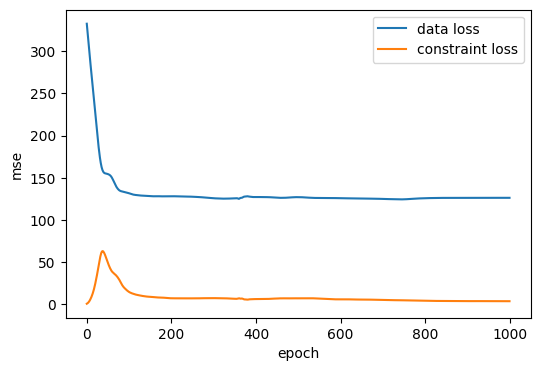

In [28]:
def plot_result(result):
    fig = plt.figure(figsize=(6, 4))
    plt.plot(result["dataloss"], label="data loss")
    plt.plot(result["constraintloss"], label="constraint loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("mse")

    return fig

fig = plot_result(result)

Function `format_prediction` reshapes prediction tensor into interpretable format, aiding visualization and analysis of predicted values across plate/grid.

In [29]:
def format_prediction(prediction, platelength, timestepcount):
    formatted = prediction.detach().numpy().reshape(timestepcount, platelength, platelength)
    return formatted


Compute, format, visualize validation predictions with heatmap animation.

(50, 20, 20)


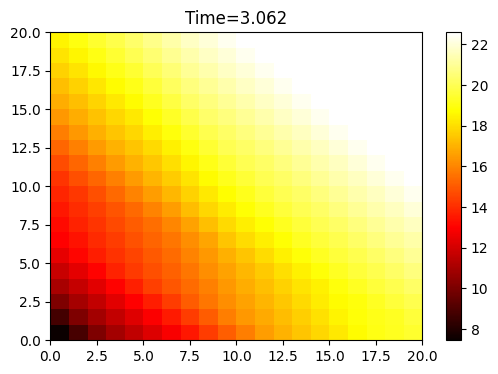

In [30]:
valid_timestep = max_iter_time - train_timestep
valid_prediction = model(valid_input)
valid_heatmap = format_prediction(valid_prediction, plate_length, valid_timestep)
print(valid_heatmap.shape)

HTML(animate_heatmap_blit(valid_heatmap, delta_t).to_jshtml())

PyTorch showcases tensor operations, gradient tracking for efficient computation, and automatic differentiation, aiding deep learning optimization tasks.

In [31]:
t1 = torch.rand(2, 3).requires_grad_(True)
t2 = torch.sum(2 * t1**3)

print(t1)
print(t1[:, 0], "\n")

tensor([[0.5285, 0.1453, 0.0106],
        [0.5154, 0.4987, 0.9908]], requires_grad=True)
tensor([0.5285, 0.5154], grad_fn=<SelectBackward0>) 



PyTorch enables gradient computation with automatic differentiation, supporting higher-order derivatives for sophisticated optimization tasks efficiently and accurately.

In [32]:
dt1 = torch.autograd.grad(t2, t1, create_graph=True)[0]
dt1_2 = torch.autograd.grad(dt1.sum(), t1, create_graph=True)[0]
print(dt1, "\n", 6*t1**2, "\n")
print(dt1_2, "\n", 12*t1)

tensor([[1.6759e+00, 1.2660e-01, 6.7985e-04],
        [1.5941e+00, 1.4921e+00, 5.8906e+00]], grad_fn=<MulBackward0>) 
 tensor([[1.6759e+00, 1.2660e-01, 6.7985e-04],
        [1.5941e+00, 1.4921e+00, 5.8906e+00]], grad_fn=<MulBackward0>) 

tensor([[ 6.3421,  1.7431,  0.1277],
        [ 6.1853,  5.9842, 11.8901]], grad_fn=<MulBackward0>) 
 tensor([[ 6.3421,  1.7431,  0.1277],
        [ 6.1853,  5.9842, 11.8901]], grad_fn=<MulBackward0>)


## Multidimension

Adapted from

https://jparkhill.netlify.app/solvingdiffusions/

Neural Density Models offer flexibility, scalability, expressiveness in modeling complex probability distributions using neural networks, requiring proper training and hyperparameter tuning.

In [33]:
class Neural_Density(nn.Module):
    """
    A neural model of a time dependent probability density on
    a vector valued state-space.

    ie: rho(t,{x_0, x_1, ... x_{state_dim}})

    for now, I'm not even enforcing normalization.
    could with a gaussian mixture or whatever.
    """
    def __init__(self, state_dim, hidden_dim = 64):
        super(Neural_Density, self).__init__()
        self.input_dim = state_dim+1 # self.register_buffer('input_dim',state_dim+1)
        self.state_dim = state_dim
        self.net = nn.Sequential(
                            nn.Linear(self.input_dim, hidden_dim),
                            nn.Softplus(),
                            nn.Linear(hidden_dim, 1),
                            nn.Softplus(),  # density is positive.
                           )
    def forward(self,t,x):
        # Just evaluate the probability at the argument.
        return self.net(torch.cat([t.unsqueeze(-1),x],-1)).squeeze()

class Reshape(nn.Module):
    def __init__(self, shp):
        super(Reshape, self).__init__()
        self.shape = shp
    def forward(self, x):
        return x.view(self.shape)

class Gaussian_Mixture_Density(nn.Module):
    def __init__(self, state_dim,
                       m_dim=1,
                       hidden_dim = 16,
                    ):
        """
        A network which parameterically
        produces gaussian output with feed-forwards
        that parameterize the mixture.
        """
        super(Gaussian_Mixture_Density, self).__init__()

        # Rho(x,y) is the density parameterized by t
        input_dim=1
        output_dim=state_dim

        self.output_dim = output_dim
        self.m_dim = m_dim
        mixture_dim = output_dim*m_dim
        self.n_corr = int((self.output_dim*(self.output_dim-1)/2.))
        self.sftpls = nn.Softplus()
        self.sftmx = nn.Softmax(dim=-1)
        self.corr_net = nn.Sequential(
                                    # tch.nn.Dropout(0.1),
                                    nn.Linear(input_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, self.n_corr*m_dim),
                                    Reshape((-1, m_dim, self.n_corr))
                                   )
        self.std_net = nn.Sequential(
                                    # tch.nn.Dropout(0.1),
                                    nn.Linear(input_dim, hidden_dim),
                                    nn.SELU(),
                                    nn.Linear(hidden_dim, mixture_dim),
                                    nn.Softplus(10.),
                                    Reshape((-1, m_dim, self.output_dim))
                                   )
        self.mu_net = nn.Sequential(
                                    # tch.nn.Dropout(0.1),
                                    nn.Linear(input_dim, hidden_dim),
                                    nn.Tanh(),
                                    nn.Linear(hidden_dim, mixture_dim),
                                    Reshape((-1, m_dim, self.output_dim))
                                   )
        self.pi_net = nn.Sequential(
                                    # tch.nn.Dropout(0.1),
                                    nn.Linear(input_dim, hidden_dim),
                                    nn.SELU(),
                                    nn.Linear(hidden_dim, m_dim),
                                    nn.Tanh(),
                                    nn.Softmax(dim=-1)
                                    )
        super(Gaussian_Mixture_Density, self).add_module("corr_net",self.corr_net)
        super(Gaussian_Mixture_Density, self).add_module("std_net",self.std_net)
        super(Gaussian_Mixture_Density, self).add_module("mu_net",self.mu_net)
        super(Gaussian_Mixture_Density, self).add_module("pi_net",self.pi_net)
    def pi(self, x):
        return self.pi_net(x)
    def mu(self, x):
        return self.mu_net(x)
    def L(self, x):
        """
        Constructs the lower diag cholesky decomposed sigma matrix.
        """
        batch_size = x.shape[0]
        L = torch.zeros(batch_size, self.m_dim, self.output_dim, self.output_dim)
        b_inds = torch.arange(batch_size).unsqueeze(1).unsqueeze(1).repeat(1, self.m_dim, self.output_dim).flatten()
        m_inds = torch.arange(self.m_dim).unsqueeze(1).unsqueeze(0).repeat(batch_size, 1, self.output_dim).flatten()
        s_inds = torch.arange(self.output_dim).unsqueeze(0).unsqueeze(0).repeat(batch_size, self.m_dim,1).flatten()
        L[b_inds, m_inds, s_inds, s_inds] = self.std_net(x).flatten()
        if self.output_dim>1:
            t_inds = torch.tril_indices(self.output_dim,self.output_dim,-1)
            txs = t_inds[0].flatten()
            tys = t_inds[1].flatten()
            bb_inds = torch.arange(batch_size).unsqueeze(1).unsqueeze(1).repeat(1, self.m_dim, txs.shape[0]).flatten()
            mt_inds = torch.arange(self.m_dim).unsqueeze(1).unsqueeze(0).repeat(batch_size, 1, txs.shape[0]).flatten()
            xt_inds = txs.unsqueeze(0).unsqueeze(0).repeat(batch_size, self.m_dim, 1).flatten()
            yt_inds = tys.unsqueeze(0).unsqueeze(0).repeat(batch_size, self.m_dim, 1).flatten()
            L[bb_inds, mt_inds, xt_inds, yt_inds] = self.corr_net(x).flatten()
        return L
    def get_distribution(self, x):
        pi_distribution = torch.distributions.Categorical(self.pi(x))
        GMM = torch.distributions.mixture_same_family.MixtureSameFamily(pi_distribution,
                            torch.distributions.MultivariateNormal(self.mu(x),
                            scale_tril=self.L(x)))
        return GMM
    def forward(self, t, x):
        return self.get_distribution(t.unsqueeze(-1)).log_prob(x).exp()
    def rsample(self, t, sample_shape = 128):
        """
        returns samples from the gaussian mixture (samples are added last dimension)
        ie: batch X dim X samp
        """
        samps_ = self.get_distribution(t).sample(sample_shape=[sample_shape])
        samps = samps_.permute(1,2,0)
        return samps
    def mean(self,t):
        return self.get_distribution(t.unsqueeze(-1)).mean
    def std(self,t):
        return torch.sqrt(self.get_distribution(t.unsqueeze(-1)).variance)

The `Neural_Heat_PDE` module enforces PDE solutions, offers loss computation, sampling, facilitating training neural density functions adhering to physics constraints.

In [34]:
class Neural_Heat_PDE(nn.Module):
    def __init__(self, state_dim = 2, batch_size = 64, initial_function=None,
                         max_time = 10.):
        """
        Defines losses to ensure Neural_Density (rho) solves a PDE
        which is hard-coded inside. (eventually to be Fokker-Plank)

        drho(t,x)/dt = ...

        The PDE is evaluated on a grid randomly chosen.
        """
        super(Neural_Heat_PDE, self).__init__()
        self.state_dim = state_dim
        self.batch_size = batch_size
        self.max_time = max_time
        if (initial_function is None):
            self.initial_function = lambda X : torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(self.state_dim),
                                     0.02*torch.eye(self.state_dim)).log_prob(X).exp()
    def x_t_sample_batch(self):
        x = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(self.state_dim),
                                                5.*torch.eye(self.state_dim)).rsample([self.batch_size])
        t = torch.distributions.uniform.Uniform(0.,self.max_time).rsample([self.batch_size])
        return x,t
    def initial_loss(self, rho):
        x,t = self.x_t_sample_batch()
        y0 = self.initial_function(x)
        fy0 = rho(torch.zeros(x.shape[0]) , x)
        return torch.pow(fy0 - y0,2.0).sum()
    def kernel_loss(self,rho):
        """
        simply the heat equation...
        """
        x_,t_ = self.x_t_sample_batch()
        x = torch.nn.Parameter(x_,requires_grad=True)
        t = torch.nn.Parameter(t_,requires_grad=True)
        f = rho(t, x)
        dfdt = torch.autograd.grad(f.sum(), t, create_graph=True, allow_unused=True)[0].sum()
        d2fdx2 = torch.einsum('ijij->',torch.autograd.functional.hessian(lambda x : rho(t_, x).sum() ,
                                        x, create_graph=True))
        differential = 0.5*d2fdx2
        return torch.pow(-dfdt + differential,2.0).sum()
    def forward(self,rho):
        """
        both these losses are evaluated over the batch'd grid
        defined by the initial condition.
        """
        return self.initial_loss(rho)+self.kernel_loss(rho)


Contour plot visualizes neural density distribution across space at time `T`, aiding pattern identification and understanding density variations.

In [35]:
X[30:50]

array([[ 0.49509343,  0.72970357,  0.53407809],
       [-0.22910877,  0.58287718, -0.33485478],
       [ 0.90698366,  1.23308339, -0.15632175],
       [ 0.15227464,  1.70963513,  0.09587337],
       [ 0.40668103,  0.06208908, -1.95736273],
       [ 0.02467847, -1.7543448 , -0.98805039],
       [-0.92283372, -1.08817136,  1.13618479],
       [-1.11923504,  0.30229036, -1.22728607],
       [ 2.94385163,  0.14836753, -0.0703781 ],
       [-2.43456939,  0.54955475,  0.65307975],
       [ 1.41621825, -0.81061475, -1.17501004],
       [ 0.59899374,  1.39579133, -1.54910183],
       [-0.52748835, -0.04755336, -0.32878771],
       [ 1.21601831,  1.82771758,  0.68860365],
       [ 1.50376591, -2.59883633, -1.56044926],
       [-0.43221043, -0.01751413,  1.01077005],
       [-0.0536725 ,  0.38138046,  0.3225046 ],
       [-1.47940481, -0.80607306,  0.15083626],
       [ 0.52052314, -0.2979381 ,  0.05443709],
       [-0.13318826,  1.64945395,  0.28757885]])